### Description
- Patient visits who were transferred within 24 hours
    - ICUs to non-ICUs
    - Non-ICUs to ICUs
- Prediction differences between labels at time 0 and 24hr
- Differences between predicted values at time 0 and time 24 compared to their corresponding true labels
- Within the patient visits who were transferred:
    - More in depth about those with largest differences between the predictions at 2 time points
    - and how they are related to the differences in predicted values vs. true labels

In [1]:
library(caret) # import this before glmnet to avoid rlang version problem
library(data.table)
library(tidyverse)
library(lubridate)
library(Matrix)
library(glmnet)
library(bit64)
library(pROC)
library(rms)

Loading required package: lattice

Loading required package: ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::lift()      masks caret::lift()
x purrr::transpose() masks data.table::transpose()


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'Matrix'


The following 

In [2]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
modeldir4 = "../../OutputTD/3_models/1_4_cohort"

In [3]:
# list.files(path="modeldir4", pattern="lightgbm_test_results.csv", full.names=TRUE, recursive=FALSE)
dir(path="modeldir4") #pattern="*.csv")

character(0)

In [4]:
# check folder and sub-folders
folder <- list.dirs(modeldir4) # this assumes being in the main folder, otherwise specify the path
folder
folder <- folder[-1]  # comment this out if the main folder also contains the script
# script.paths <- paste(folder,"/","process.R", sep="")
# for (i in script.paths) {source(i)}

[1] "../../OutputTD/3_models/1_4_cohort"                        
[2] "../../OutputTD/3_models/1_4_cohort/death_24hr_max_label"   
[3] "../../OutputTD/3_models/1_4_cohort/death_24hr_recent_label"
[4] "../../OutputTD/3_models/1_4_cohort/first_label"

In [5]:
# sub-folders
sub.folders <- list.dirs(modeldir4)[-1]
sub.folders

[1] "../../OutputTD/3_models/1_4_cohort/death_24hr_max_label"   
[2] "../../OutputTD/3_models/1_4_cohort/death_24hr_recent_label"
[3] "../../OutputTD/3_models/1_4_cohort/first_label"

In [9]:
cohort <- read.csv(file.path(cohortdir, '1_4_cohort.csv'))
nrow(cohort)
colnames(cohort)

[1] 43980

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"

In [73]:
cohort_test <-  cohort %>% mutate(admit_time = ymd_hms(admit_time)) %>% 
                    mutate(adm_year = year(admit_time)) %>% filter(adm_year > 2018)
nrow(cohort_test)
table(cohort_test$adm_year)

[1] 12418


 2019  2020 
10115  2303 

In [74]:
for (f in sub.folders){
    print(f)
    out <- read.csv(paste0(f,"/","lightgbm_test_results.csv")) %>% select(pat_enc_csn_id_coded, predictions)
    cohort_test <- cohort_test %>% inner_join(out)
#     cohort_test[ , ncol(cohort_test) + 1] <- out$predictions
#     newcolname <- paste0("pred_", str_sub(f, start=-12))
    newcolname <- paste0("pred_", str_sub(f, start=36, end=-7))
    print(newcolname)
#     cohort_test <- cohort_test %>% rename(newcolname = predictions)
#     print(colnames(cohort_test))
    colnames(cohort_test)[ncol(cohort_test)] <- newcolname
}

[1] "../../OutputTD/3_models/1_4_cohort/death_24hr_max_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_death_24hr_max"
[1] "../../OutputTD/3_models/1_4_cohort/death_24hr_recent_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_death_24hr_recent"
[1] "../../OutputTD/3_models/1_4_cohort/first_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_first"


In [75]:
nrow(cohort_test)
colnames(cohort_test)
summary(cohort_test)

[1] 12418

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "pred_death_24hr_max"             "pred_death_24hr_recent"         
[21] "pred_first"

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:12418       Min.   :1.313e+11    Min.   :33212811       
 Class :character   1st Qu.:1.313e+11    1st Qu.:35996148       
 Mode  :character   Median :1.313e+11    Median :39994636       
                    Mean   :1.313e+11    Mean   :40003546       
                    3rd Qu.:1.313e+11    3rd Qu.:43886508       
                    Max.   :1.313e+11    Max.   :48026130       
                                                                
   admit_time                   label_max24     label_24hr_recent
 Min.   :2019-01-01 00:03:00   Min.   :0.0000   Min.   :0.0000   
 1st Qu.:2019-04-13 00:01:30   1st Qu.:0.0000   1st Qu.:0.0000   
 Median :2019-08-04 21:50:30   Median :0.0000   Median :0.0000   
 Mean   :2019-08-08 00:19:00   Mean   :0.1512   Mean   :0.1033   
 3rd Qu.:2019-12-01 06:24:15   3rd Qu.:0.0000   3rd Qu.:0.0000   
 Max.   :2020-03-31 07:00:00   Max.   :1.0000   Max.   :1.0000   
                  

In [122]:
write.csv(cohort_test, file.path(modeldir4, "cohort_test_preds.csv"), row.names=FALSE)

### Patient visits who changed labels

In [81]:
summary(cohort$death_24hr_recent_label)
summary(cohort_test$death_24hr_recent_label)
summary(cohort_test$acute_to_critical_label_recent)
summary(cohort_test$critical_to_acute_label_recent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.09468 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.104   0.000   1.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02247 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.04236 0.00000 1.00000 

In [87]:
transfers <- cohort_test %>% filter(death_24hr_recent_label != first_label)
summary(transfers)

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:805         Min.   :1.313e+11    Min.   :33304897       
 Class :character   1st Qu.:1.313e+11    1st Qu.:35937311       
 Mode  :character   Median :1.313e+11    Median :40224264       
                    Mean   :1.313e+11    Mean   :40067966       
                    3rd Qu.:1.313e+11    3rd Qu.:43924002       
                    Max.   :1.313e+11    Max.   :47867256       
                                                                
   admit_time                   label_max24     label_24hr_recent
 Min.   :2019-01-03 03:54:00   Min.   :0.0000   Min.   :0.0000   
 1st Qu.:2019-04-11 00:11:00   1st Qu.:1.0000   1st Qu.:0.0000   
 Median :2019-08-11 14:25:00   Median :1.0000   Median :0.0000   
 Mean   :2019-08-09 01:03:59   Mean   :0.9913   Mean   :0.3379   
 3rd Qu.:2019-11-29 04:20:00   3rd Qu.:1.0000   3rd Qu.:1.0000   
 Max.   :2020-03-30 20:27:00   Max.   :1.0000   Max.   :1.0000   
                  

In [86]:
sum(transfers$critical_to_acute_label_recent)
sum(transfers$acute_to_critical_label_recent)
sum(transfers$critical_to_acute_label_recent) + sum(transfers$acute_to_critical_label_recent)

[1] 526

[1] 279

[1] 805

In [89]:
write.csv(transfers, file.path(modeldir4, "transfers.csv"), row.names=FALSE)

### Patient visits with big differences in predictions at 2 time points

In [103]:
long3 <- gather(cohort_test, labels, predictions, pred_death_24hr_max:pred_first, factor_key=TRUE)
long2 <- long3 %>% filter(labels != 'pred_death_24hr_max')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



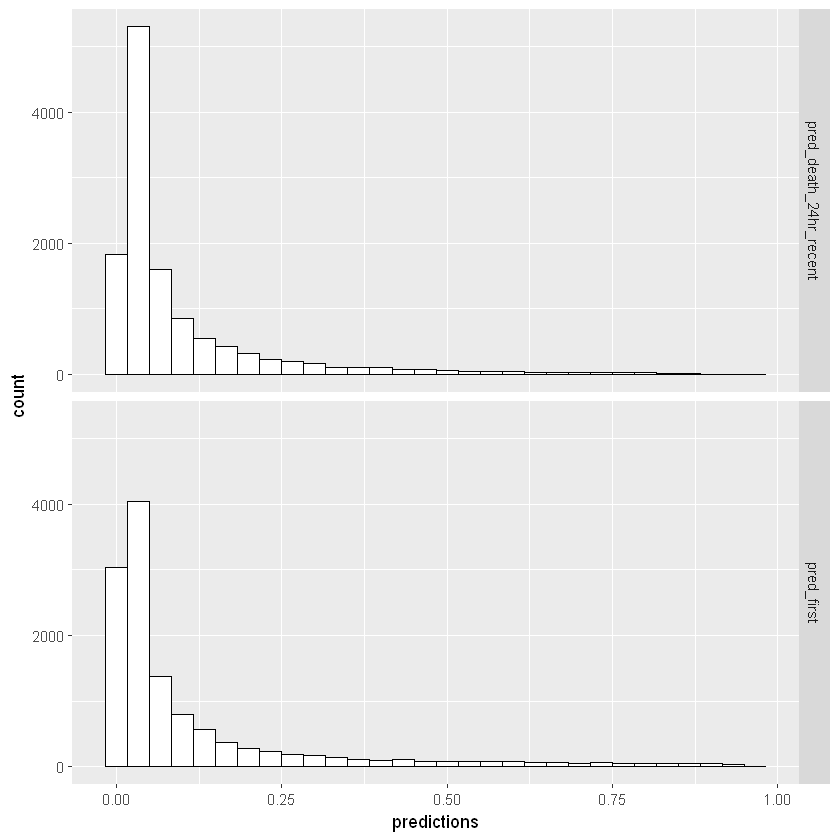

In [107]:
ggplot(long2, aes(x = predictions)) +
  geom_histogram(fill = "white", colour = "black") +
  facet_grid(labels ~ .)

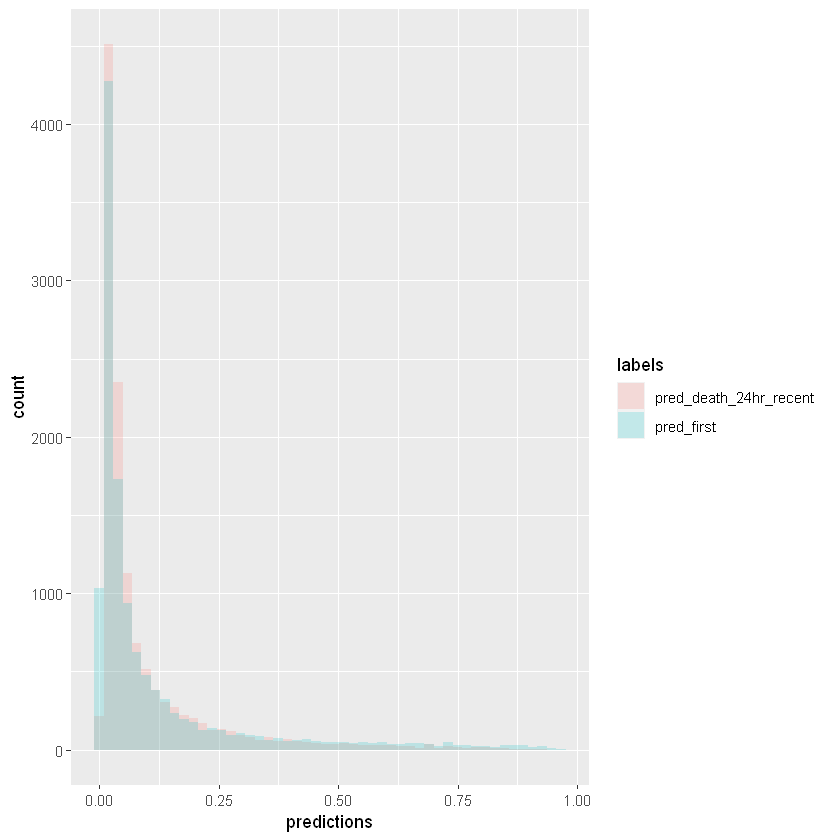

In [106]:
ggplot(long2, aes(x = predictions, fill = labels)) +         
  geom_histogram(position = "identity", alpha = 0.2, bins = 50)

In [131]:
cohort_test <- cohort_test %>% mutate(diff0_24 = round(pred_first - pred_death_24hr_recent, 2),
                                      diff0_True = round(pred_first - first_label, 2),
                                      diff24_True = round(pred_death_24hr_recent - death_24hr_max_label, 2))

5%   10%   20%   30%   40%   50%   60%   70%   80%   90%   95% 
-0.05 -0.03 -0.01 -0.01  0.00  0.00  0.00  0.01  0.03  0.10  0.18

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.42000 -0.01000  0.00000  0.01798  0.02000  0.73000 

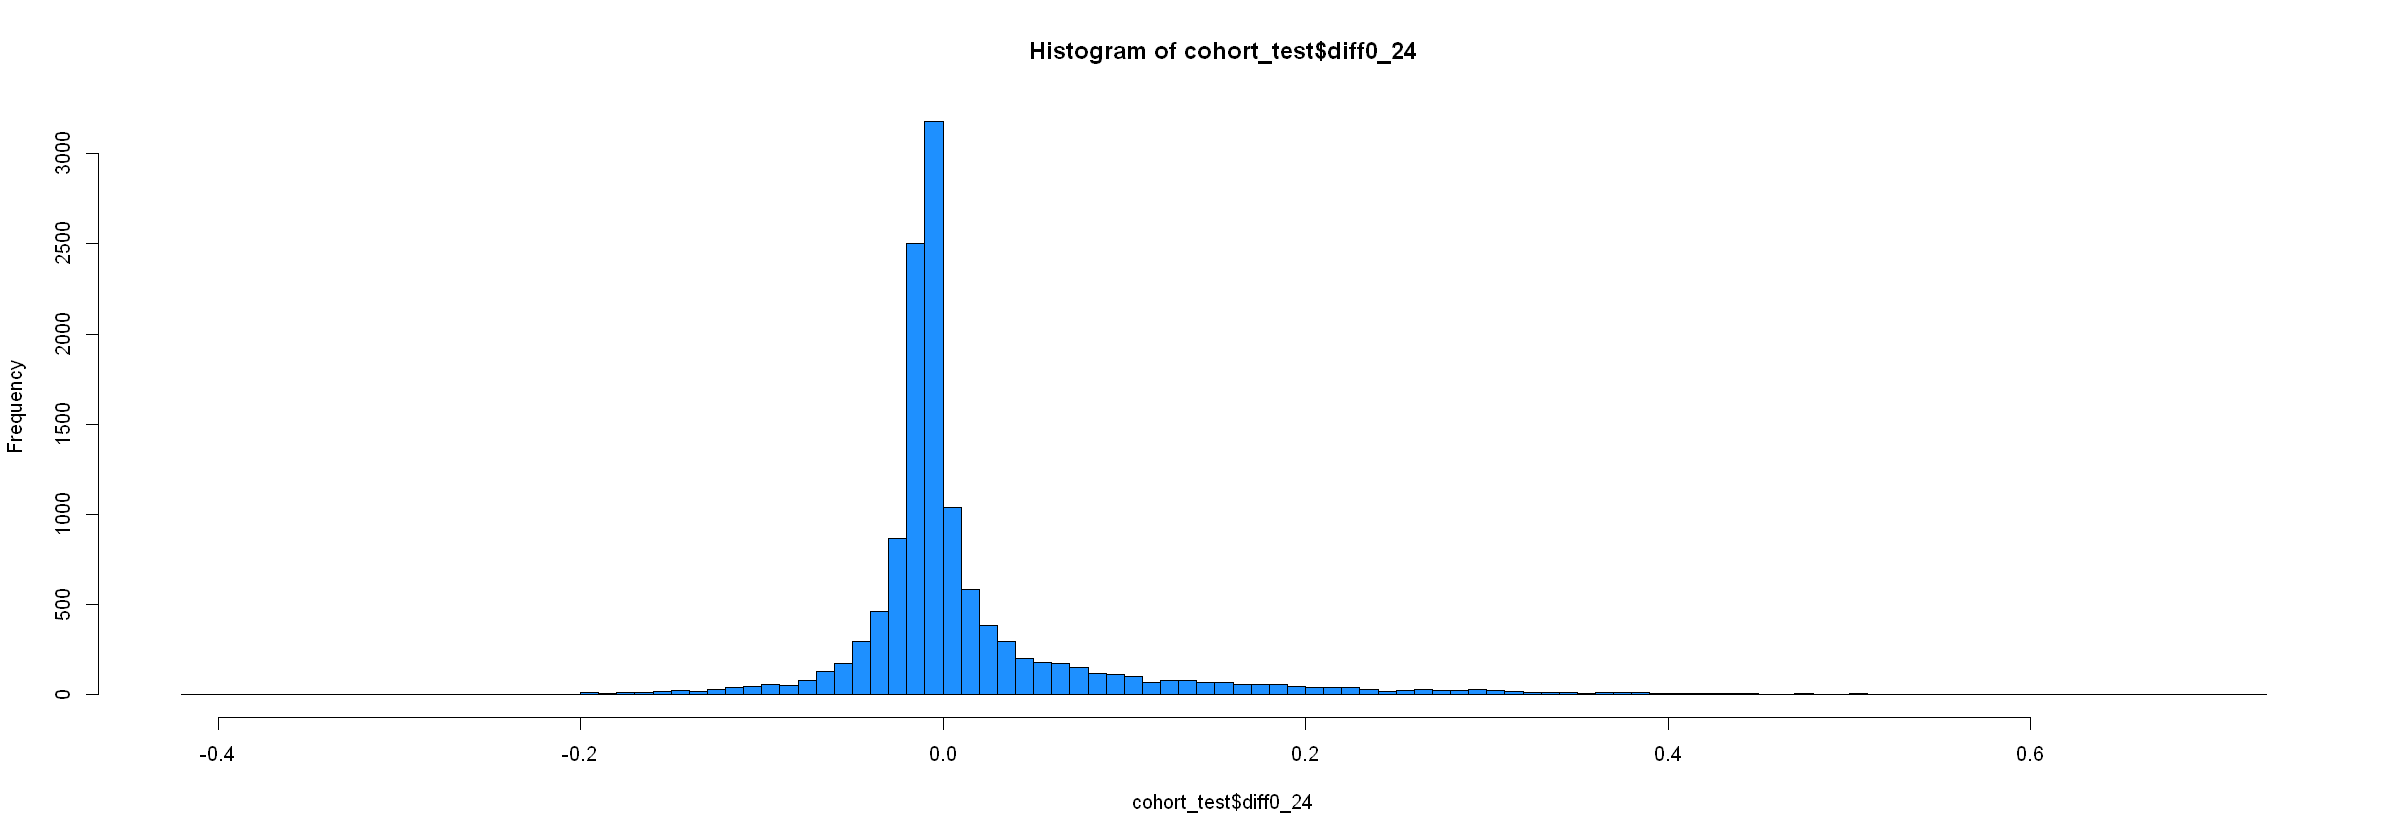

In [130]:
options(repr.plot.width=20, repr.plot.height=7)

quantile(cohort_test$diff0_24, c(.05, .1, .2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95)) 
summary(cohort_test$diff0_24)
hist(cohort_test$diff0_24, col='dodgerblue', breaks=100)

[1] 191

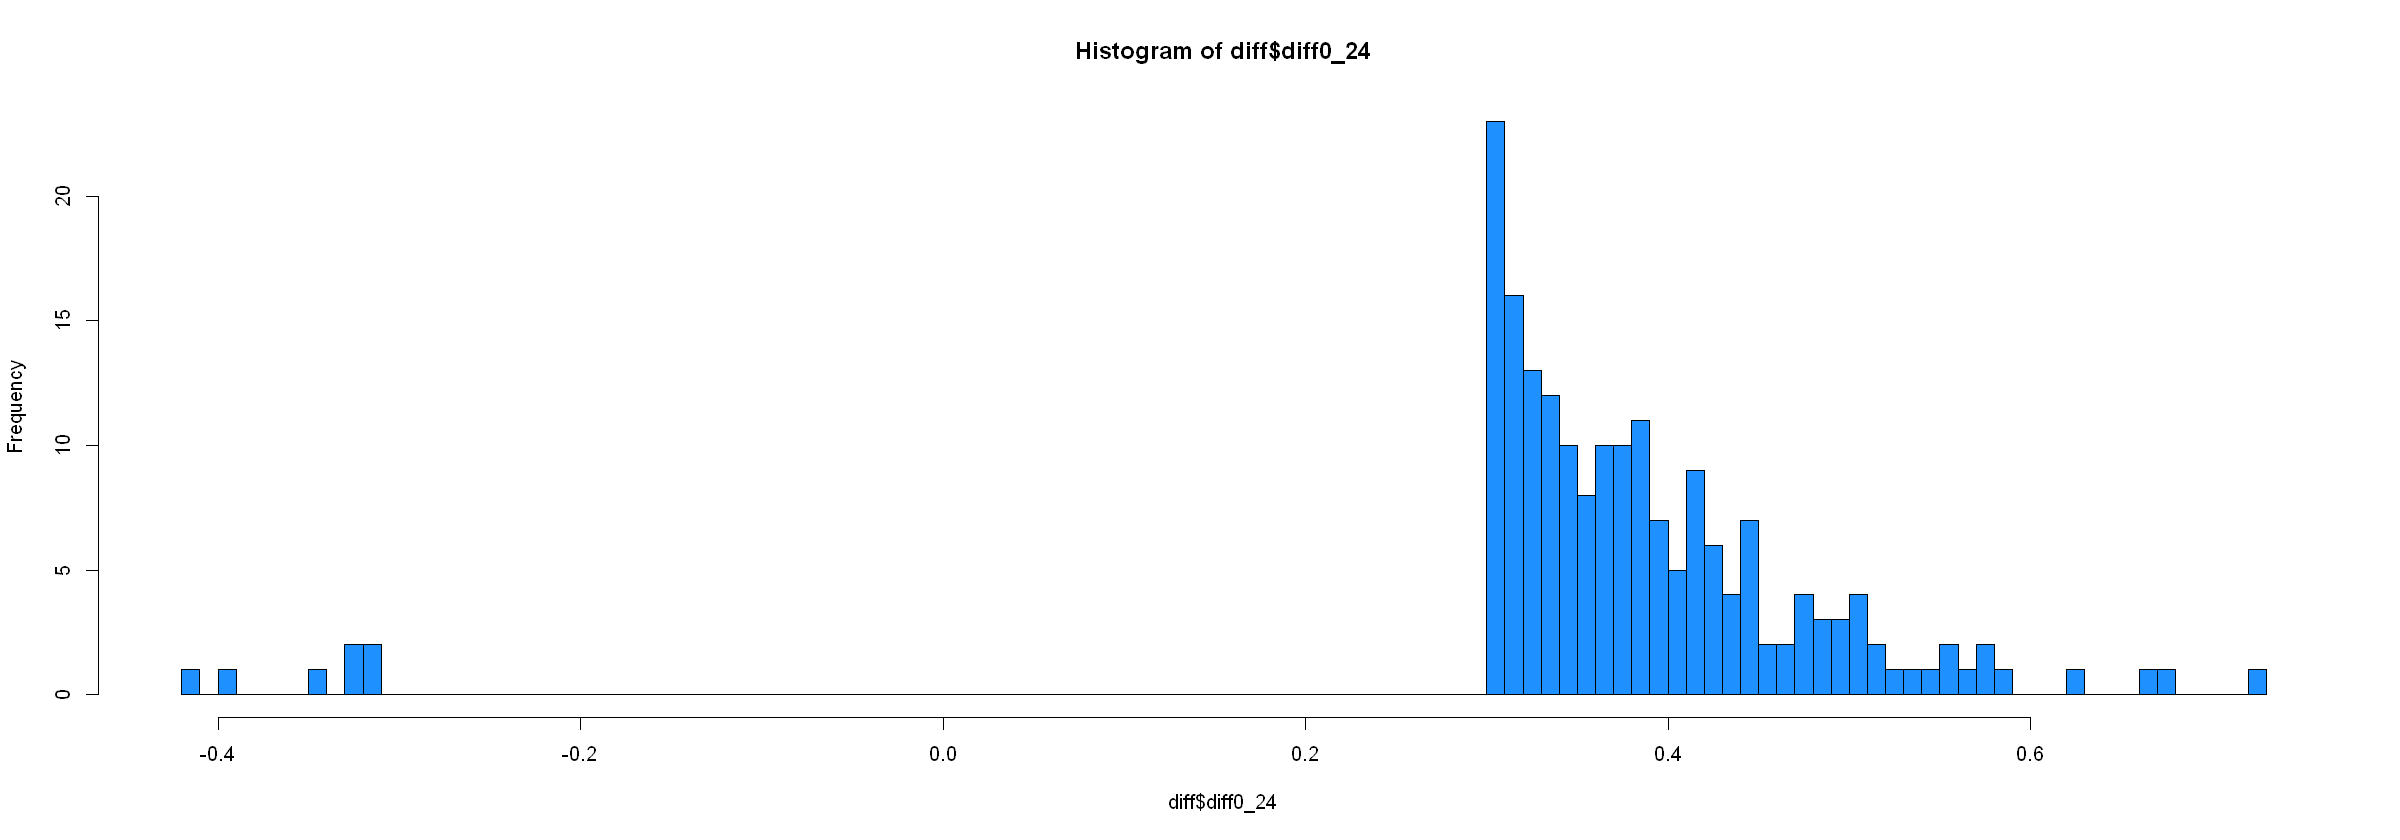

In [128]:
diff <- cohort_test %>% filter(abs(diff0_24) > 0.3)
nrow(diff) # /nrow(cohort_test) *100 # about 1.54% 
hist(diff$diff0_24, col='dodgerblue', breaks=100)

In [138]:
write.csv(diff, file.path(modeldir4, "preds_diff_0_24.csv"), row.names=FALSE)

### Patient visits predictions vs. truth


In [132]:
summary(cohort_test$diff0_True)
summary(cohort_test$diff24_True)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.990000  0.010000  0.030000 -0.007673  0.070000  0.930000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.99000  0.01000  0.03000 -0.05359  0.06000  0.76000 

In [139]:
colnames(cohort_test)

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "pred_death_24hr_max"             "pred_death_24hr_recent"         
[21] "pred_first"                      "diff0_24"                       
[23] "diff0_True"                      "diff24_True"

In [134]:
diff3 <- gather(cohort_test, diffs, values, diff0_24:diff24_True, factor_key=TRUE)
diff2 <- diff3 %>% filter(diffs != 'diff0_24')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



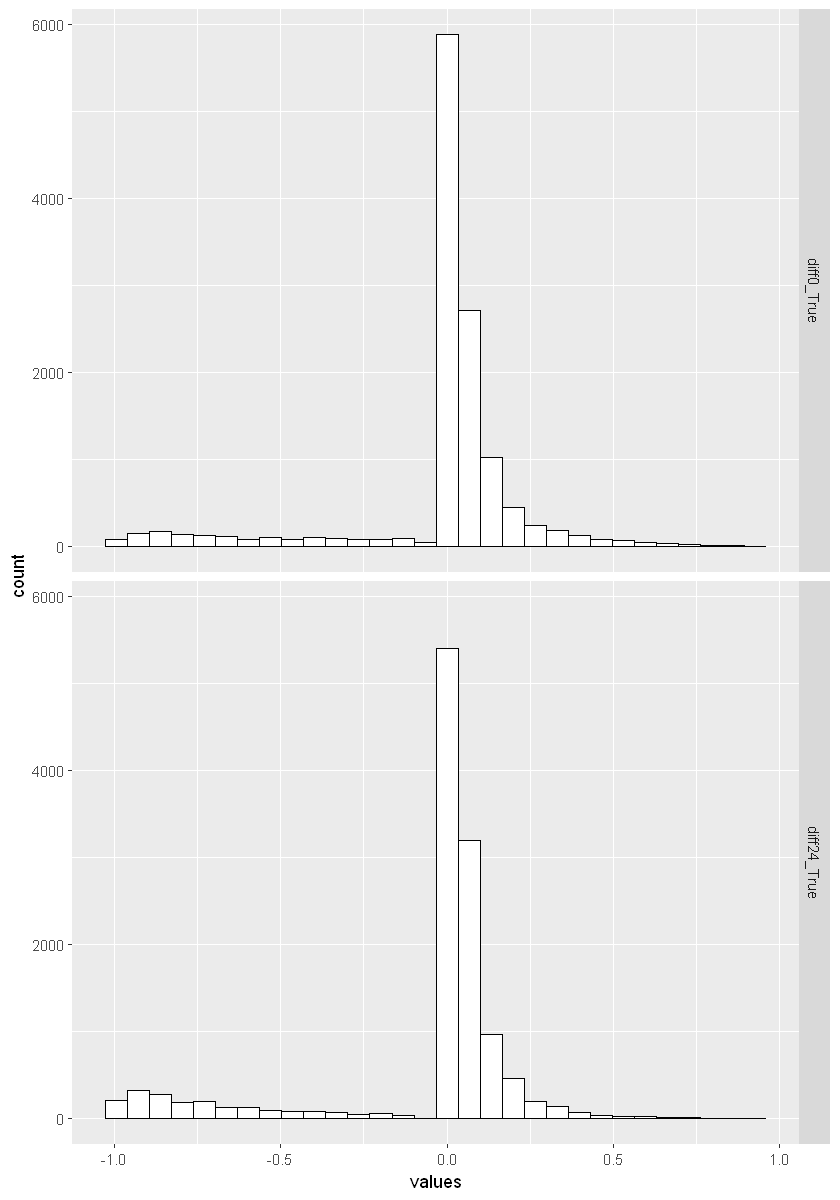

In [137]:
options(repr.plot.width=7, repr.plot.height=10)

ggplot(diff2, aes(x = values)) +
  geom_histogram(fill = "white", colour = "black") +
  facet_grid(diffs ~ .)

### 

In [141]:
orders4 <- read.csv(file.path(datadir, 'coh5_order_code_counts.csv'))
nrow(orders4) # 4322665

[1] 4386107

In [ ]:
values <- 